In [ ]:
# Import statements
import numpy as np
import pandas as pd
import sqlite3

In [ ]:
# Connecting to sqlite 
conn = sqlite3.connect('pudl_subset.sqlite')

# Creating a cursor object using the cursor() method 
cursor = conn.cursor()

In [ ]:
# Show all tables in database
tables_query = """SELECT name FROM sqlite_master  
                  WHERE type='table';"""
cursor.execute(tables_query)
table_list = cursor.fetchall()
print(table_list)

### Database columns explained
Descriptions from: https://data.catalyst.coop/pudl/out_ferc1__yearly_all_plants

- report_year: "Four-digit year in which the data was reported."
- utility_id_ferc1: "PUDL-assigned utility ID, identifying a FERC1 utility. This is an auto- incremented ID and is not expected to be stable from year to year."
- utility_id_pudl: "A manually assigned PUDL utility ID. May not be stable over time."
- utility_name_ferc1: "Name of the responding utility, as it is reported in FERC Form 1. For human readability only."
- plant_id_pudl: "A manually assigned PUDL plant ID. May not be constant over time."
- plant_id_ferc1: "Algorithmically assigned PUDL FERC Plant ID. WARNING: NOT STABLE BETWEEN PUDL DB INITIALIZATIONS."
- plant_name_ferc1: "Name of the plant, as reported to FERC. This is a freeform string, not guaranteed to be consistent across references to the same plant."
- net_generation_mwh: "Net electricity generation for the specified period in megawatt-hours (MWh)."
- fuel_cost_per_mwh: "Derived from MCOE, a unit level value. Average fuel cost per MWh of heat content in nominal USD."
- plant_type: "Type of plant."
- fuel_type: "Type of fuel."
- net_load_mwh: "Net output for load (net generation - energy used for pumping) in megawatt- hours."

### Import database into Pandas dataframe
There is currently only one table in the database. This is how you import it into Pandas.

In [97]:
pudl_yearly_df = pd.read_sql_query("SELECT * FROM yearly_plant_generation", conn)

### Import monthly data into Pandas from database
This is likely the data we will use the most

In [85]:
# This doesn't currently work
pudl_monthly_df = pd.read_sql_query("SELECT * FROM monthly_generation_grouped", conn)
pudl_monthly_df.tail()

,report_date,state,SUM(net_generation_mwh)
14399,2024-01-01,VT,NaN
14400,2024-01-01,WA,NaN
14401,2024-01-01,WI,NaN
14402,2024-01-01,WV,NaN
14403,2024-01-01,WY,NaN


In [88]:
# Filter out entries with report date '2024-01-01'
pudl_monthly_df = pudl_monthly_df[pudl_monthly_df['report_date'] != '2024-01-01']

In [91]:
# Convert report_date to datetime
pudl_monthly_df['report_date'] = pd.to_datetime(pudl_monthly_df['report_date'])

# Filter the DataFrame for entries with report_date after 2018-01-01
filtered_pudl_monthly_df = pudl_monthly_df[pudl_monthly_df['report_date'] > '2017-12-01']

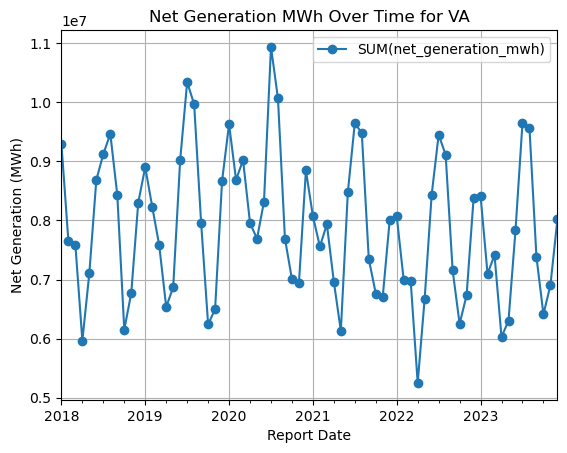

In [95]:
import matplotlib.pyplot as plt

# Filter the DataFrame for entries where the state is 'VA'
va_data = filtered_pudl_monthly_df[filtered_pudl_monthly_df['state'] == 'VA']

# Plot the data
va_data.plot(x='report_date', y='SUM(net_generation_mwh)', kind='line', marker='o')

# Add labels and title
plt.xlabel('Report Date')
plt.ylabel('Net Generation (MWh)')
plt.title('Net Generation MWh Over Time for VA')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Different values for type of plant
plant_types = pudl_yearly_df['plant_type'].unique()
print("Different plant types:", plant_types)

# Different values for type of fuel
fuel_types = pudl_yearly_df['fuel_type'].unique()
print("Different fuel types:", fuel_types)

In [ ]:
# Function to get the schema of a table
def get_table_schema(table_name):
    schema_query = f"PRAGMA table_info({table_name});"
    cursor.execute(schema_query)
    schema = cursor.fetchall()
    return schema

# Get schema for each table
for table in table_list:
    table_name = table[0]
    schema = get_table_schema(table_name)
    print(f"Schema for table {table_name}:")
    for column in schema:
        print(f"  {column[1]} ({column[2]})")
    print("\n")

In [ ]:
# Query to select the first few rows of the yearly_plant_generation table
yearly_plant_generation = pd.read_sql_query("SELECT * FROM yearly_plant_generation", conn)

# Display the head of the dataframe
yearly_plant_generation.head()

In [ ]:
# Group by report_year and state, then sum the net_generation_mwh for each group
combined_states_yearly_df = yearly_plant_generation.groupby(['report_year', 'state'])['net_generation_mwh'].sum().reset_index()

# Display the combined dataframe
combined_states_yearly_df.tail()

In [ ]:
# Filter out states with zero net generation
filtered_yearly_plant_generation = yearly_plant_generation[yearly_plant_generation['net_generation_mwh'] > 0]

# Group by report_year and calculate the mean of net_generation_mwh for each year
average_generation_per_year = filtered_yearly_plant_generation.groupby('report_year')['net_generation_mwh'].mean().reset_index()

# Display the average generation per year
average_generation_per_year

In [ ]:
import matplotlib.pyplot as plt

# Filter data for the states TX, VA, and NC since 2010
states_to_plot = ['TX', 'VA', 'NC']
filtered_data = combined_states_yearly_df[(combined_states_yearly_df['state'].isin(states_to_plot)) & (combined_states_yearly_df['report_year'] >= 2010)]

# Plot the data for each state
for state in states_to_plot:
    state_data = filtered_data[filtered_data['state'] == state]
    plt.plot(state_data['report_year'], state_data['net_generation_mwh'], marker='o', label=state)

# Plot the average generation per year since 2010
average_data = average_generation_per_year[average_generation_per_year['report_year'] >= 2010]
plt.plot(average_data['report_year'], average_data['net_generation_mwh'], marker='o', linestyle='--', label='Average')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Net Generation (MWh)')
plt.title('Net Generation MWh for TX, VA, NC and Average Since 2010')
plt.legend()
plt.grid(True)

# Set y-axis to logarithmic scale
plt.yscale('log')

plt.show()

In [ ]:
# Query to select entries from yearly_plant_generation where state is VA
va_entries_query = "SELECT * FROM yearly_plant_generation WHERE state = 'VA'"

# Execute the query and store the result in a dataframe
va_entries_df = pd.read_sql_query(va_entries_query, conn)

# Display the dataframe
#va_entries_df

In [ ]:
# Group the dataframe by report_year and calculate the sum of net_generation_mwh and net_load_mwh for each year
grouped_va_entries_df = va_entries_df.groupby('report_year')[['net_generation_mwh', 'net_load_mwh']].sum(numeric_only=True)

# Display the grouped dataframe
grouped_va_entries_df

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
grouped_va_entries_df.plot(y=['net_generation_mwh'], kind='line', marker='o')
plt.title('Net Generation and Net Load in VA Over Years')
plt.xlabel('Year')
plt.ylabel('MWh')
plt.grid(True)
plt.show()

In [ ]:
import os
import pandas as pd

# Define the folder path
folder_path = 'data_center_locations'

# Initialize an empty list to store dataframes
dataframes = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Concatenate all dataframes into a single dataframe
all_locations_df = pd.concat(dataframes, ignore_index=True)

# Display the combined dataframe
all_locations_df.head()

In [ ]:
# Filter the DataFrame to include only North American values
north_america_df = all_locations_df[all_locations_df['Continent'] == 'North America']

# Display the filtered DataFrame
north_america_df

In [ ]:
# Extract state values from the Location column
all_locations_df['State'] = all_locations_df['Location'].str.extract(r',\s*([A-Z]{2})\b')

# Display the updated dataframe
all_locations_df.head()